
PREDICTABILITY ANALYSIS

1/5 Caricamento dati...
✓ Sales shape: (30490, 1947)
✓ Sales matrix: (30490, 1913)

2/5 Calcolo features vettorizzato (~1-2 min)...
✓ Features calcolate: (30490, 13)

3/5 Clustering K-means...
✓ Cluster distribuzione:
cluster
0      353
1    12908
2     4074
3     6623
4     6532
Name: count, dtype: int64

4/5 Difficulty labels...
✓ Difficulty distribuzione:
difficulty
Medium    18316
Hard      10317
Easy       1857
Name: count, dtype: int64

5/5 Visualizzazioni & salvataggio...
✓ Saved: ../data/predictability_results/predictability_clusters.png
✓ Saved: ../data/predictability_results/cluster_heatmap.png
✓ Saved: ../data/predictability_results/serie_cluster_difficulty.csv
✓ Saved: ../data/predictability_results/cluster_centers.csv

SUMMARY
Serie totali: 30490
Cluster: 5
Easy    :   1857 (  6.1%)
Medium  :  18316 ( 60.1%)
Hard    :  10317 ( 33.8%)


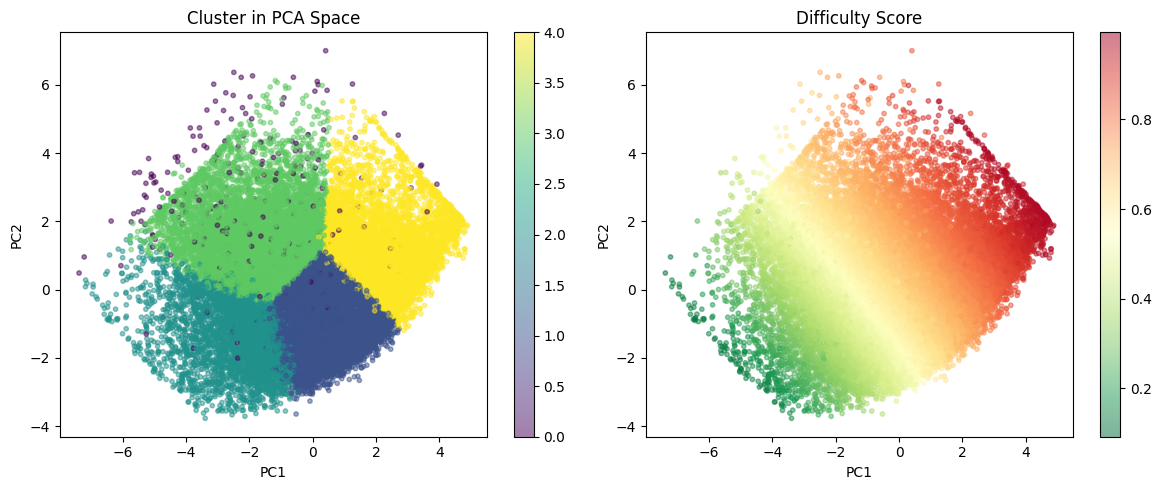

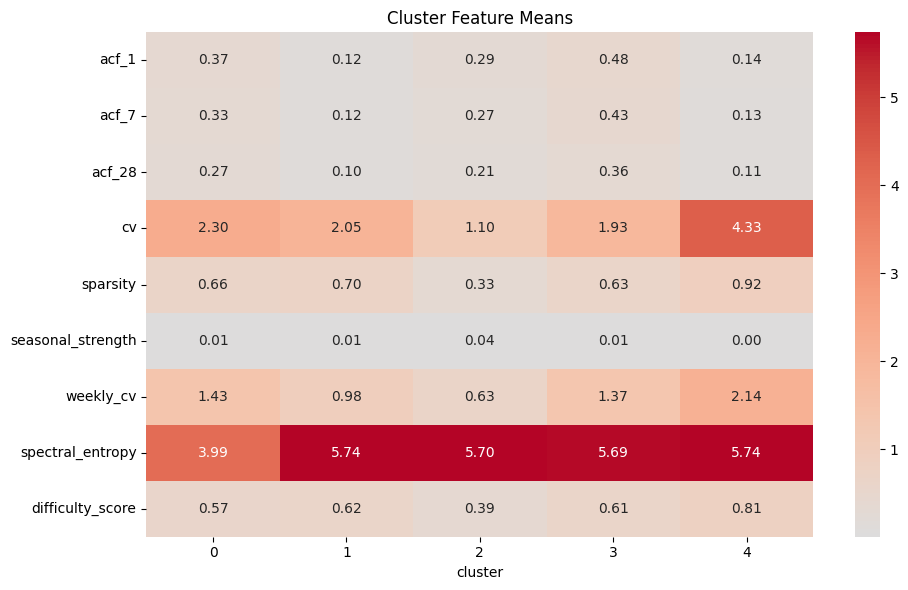

In [1]:
"""
Predictability Analysis & Clustering
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.signal import periodogram

# ============================================================================
# SETUP
# ============================================================================

print("\n" + "="*80)
print("PREDICTABILITY ANALYSIS")
print("="*80 + "\n")

DATA_PATH = Path("../data/raw")
OUTPUT_DIR = Path("../data/predictability_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# 1. CARICAMENTO DATI
# ============================================================================

print("1/5 Caricamento dati...")

sales = pd.read_csv(DATA_PATH / "sales_train_evaluation.csv")
print(f"✓ Sales shape: {sales.shape}")

id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
train_days = 1913
train_cols = [f'd_{i}' for i in range(1, train_days + 1)]

sales_matrix = sales[train_cols].values
print(f"✓ Sales matrix: {sales_matrix.shape}")

# ============================================================================
# 2. CALCOLO FEATURES VETTORIZZATO
# ============================================================================

print("\n2/5 Calcolo features vettorizzato (~1-2 min)...")

features_df = pd.DataFrame({'id': sales['id']})

# Statistiche di base
features_df['mean'] = sales_matrix.mean(axis=1)
features_df['std'] = sales_matrix.std(axis=1)
features_df['min'] = sales_matrix.min(axis=1)
features_df['max'] = sales_matrix.max(axis=1)
features_df['cv'] = features_df['std'] / (features_df['mean'] + 1e-10)
features_df['sparsity'] = (sales_matrix == 0).mean(axis=1)

# Autocorrelazioni
def acf_vectorized(X, lag):
    n = X.shape[1]
    if lag >= n:
        return np.zeros(X.shape[0])
    X_centered = X - X.mean(axis=1, keepdims=True)
    var = (X_centered ** 2).sum(axis=1)
    return (X_centered[:, :-lag] * X_centered[:, lag:]).sum(axis=1) / (var + 1e-10)

for lag in [1, 7, 28]:
    features_df[f'acf_{lag}'] = acf_vectorized(sales_matrix, lag)

# Seasonal strength
def seasonal_strength_vectorized(X, period=7):
    n_samples, n_days = X.shape
    n_periods = n_days // period
    X_truncated = X[:, :n_periods * period]
    X_reshaped = X_truncated.reshape(n_samples, n_periods, period)
    seasonal_pattern = X_reshaped.mean(axis=1)
    seasonal_component = np.tile(seasonal_pattern[:, np.newaxis, :], (1, n_periods, 1)).reshape(n_samples, -1)
    var_seasonal = seasonal_pattern.var(axis=1)
    residuals = X_truncated - seasonal_component
    var_residual = residuals.var(axis=1)
    strength = var_seasonal / (var_seasonal + var_residual + 1e-10)
    return np.clip(strength, 0, 1)

features_df['seasonal_strength'] = seasonal_strength_vectorized(sales_matrix)

# Weekly CV
def weekly_cv_vectorized(X, period=7):
    n_samples, n_days = X.shape
    n_weeks = n_days // period
    X_truncated = X[:, :n_weeks * period]
    weeks = X_truncated.reshape(n_samples, n_weeks, period).mean(axis=2)
    return weeks.std(axis=1) / (weeks.mean(axis=1) + 1e-10)

features_df['weekly_cv'] = weekly_cv_vectorized(sales_matrix)

# Spectral Entropy (sample 10%)
n_sample = len(sales_matrix) // 10
sample_indices = np.random.RandomState(42).choice(len(sales_matrix), n_sample, replace=False)

def spectral_entropy(ts):
    ts_detrended = ts - np.linspace(ts[0], ts[-1], len(ts))
    freqs, psd = periodogram(ts_detrended)
    psd_norm = psd / (psd.sum() + 1e-10)
    return entropy(psd_norm + 1e-10)

spec_vals = np.full(len(sales_matrix), np.nan)
for idx in sample_indices:
    spec_vals[idx] = spectral_entropy(sales_matrix[idx])
spec_mean = np.nanmean(spec_vals)
spec_vals[np.isnan(spec_vals)] = spec_mean
features_df['spectral_entropy'] = spec_vals

print(f"✓ Features calcolate: {features_df.shape}")

# ============================================================================
# 3. CLUSTERING
# ============================================================================

print("\n3/5 Clustering K-means...")

cluster_features = [
    'acf_1', 'acf_7', 'acf_28',
    'cv', 'sparsity',
    'seasonal_strength', 'weekly_cv',
    'spectral_entropy'
]

X = features_df[cluster_features].fillna(0)
for col in cluster_features:
    p99 = X[col].quantile(0.99)
    X[col] = X[col].clip(upper=p99)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
features_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✓ Cluster distribuzione:\n{features_df['cluster'].value_counts().sort_index()}")

# ============================================================================
# 4. DIFFICULTY LABELS
# ============================================================================

print("\n4/5 Difficulty labels...")

X_norm = X.copy()
for c in cluster_features:
    X_norm[c] = (X[c] - X[c].min()) / (X[c].max() - X[c].min() + 1e-10)

difficulty_score = (
    0.25 * X_norm['sparsity'] +
    0.25 * X_norm['cv'] +
    0.25 * (1 - X_norm['seasonal_strength']) +
    0.15 * X_norm['spectral_entropy'] +
    0.10 * X_norm['weekly_cv']
)

features_df['difficulty_score'] = difficulty_score
features_df['difficulty'] = pd.cut(
    difficulty_score,
    bins=3,
    labels=['Easy', 'Medium', 'Hard']
)

cluster_summary = features_df.groupby('cluster')[cluster_features + ['difficulty_score']].mean()

print(f"✓ Difficulty distribuzione:\n{features_df['difficulty'].value_counts()}")

# ============================================================================
# 5. VISUALIZZAZIONI & SALVATAGGIO
# ============================================================================

print("\n5/5 Visualizzazioni & salvataggio...")

# PCA plots
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['cluster'],
                          cmap='viridis', alpha=0.5, s=10)
axes[0].set_title("Cluster in PCA Space")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
fig.colorbar(scatter, ax=axes[0])

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['difficulty_score'],
                           cmap='RdYlGn_r', alpha=0.5, s=10)
axes[1].set_title("Difficulty Score")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
fig.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "predictability_clusters.png", dpi=150, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/predictability_clusters.png")

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary.T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Cluster Feature Means")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "cluster_heatmap.png", dpi=150, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/cluster_heatmap.png")

# Salvataggi
features_df = features_df.merge(sales[id_cols], on='id', how='left')
features_df.to_csv(OUTPUT_DIR / "serie_cluster_difficulty.csv", index=False)
print(f"✓ Saved: {OUTPUT_DIR}/serie_cluster_difficulty.csv")

centers_df = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)
centers_df["cluster"] = range(n_clusters)
centers_df.to_csv(OUTPUT_DIR / "cluster_centers.csv", index=False)
print(f"✓ Saved: {OUTPUT_DIR}/cluster_centers.csv")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Serie totali: {len(features_df)}")
print(f"Cluster: {n_clusters}")
for diff, n in features_df["difficulty"].value_counts().sort_index().items():
    pct = n / len(features_df) * 100
    print(f"{diff:8s}: {n:6d} ({pct:5.1f}%)")
